In [1]:
#!pip install --upgrade ~/Development/repos/tradeframework
#!pip install --upgrade ~/Development/repos/tradeframework-insights
#!pip install --upgrade ~/Development/repos/quantutils
#!pip install --upgrade ~/Development/repos/marketinsights-price-aggregator

# Pkg imports
# TODO - dynamic import of SandboxEnv
from tradeframework.environments import SandboxEnvironment  
from marketinsights.api.aggregator import MarketDataAggregator
from marketinsights.remote.ml import MIAssembly
from marketinsights.remote.models import MIModelServer
import quantutils.dataset.pipeline as ppl

# Dev imports
import pandas as pd
import numpy as np

#import matplotlib
#%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

import warnings
warnings.filterwarnings(action='ignore')


2023-03-27 22:15:56.681443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 22:15:56.804616: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-27 22:15:56.804638: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-27 22:15:57.790613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
data_config = [
    {
        "ID": "MDS",
        "class": "MDSConnector",
        "opts": {
            "location": "http://pricestore.192.168.1.203.nip.io"
        },
        "timezone": "UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                    {
                        "ID": "WallSt-hourly",
                        "sample_unit": "H"
                    },
                    {
                        "ID": "D&J-IND",
                        "sample_unit": "5min"
                    }
                ]
            },
            {
                "ID": "SPY",
                "sources": [
                    {
                        "ID":"SP500-hourly",
                        "sample_unit":"H"
                    },
                    {
                        "ID":"SANDP-500",
                        "sample_unit":"5min"
                    }
                ]
            }
        ]
    }
]


## Get Market Data
aggregator = MarketDataAggregator(data_config)
   
#start = "2013-01-01" # Train period
#end = "2018-08-01"

start="2018-08-02" # Test period
end="2018-12-31"

start="2016-07-06"
end="2016-07-15"

marketData = aggregator.getData(mkts=["DOW"], sample_unit="H", start=start, end=end, aggregate=True, debug=False)
print("Data Loaded")
#marketData = marketData.xs("mID")
#marketData = marketData.tz_convert("US/Eastern", level="Date_Time")
#marketData = marketData.unstack(level=0).dropna(axis=1).stack() # Remove rows that don't have values from all markets
#tickers = marketData.index.get_level_values("mID").unique().values


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 16.62it/s]

Data Loaded


In [3]:
modelsvr = MIModelServer(secret="marketinsights-k8s-cred")

In [6]:
env = SandboxEnvironment("TradeFair", "US/Eastern")
env.createAssets(marketData)

p = env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("EqualWeightsOptimizer"))
env.setPortfolio(p)

# Create baseline as an unweighted asset
baseline = env.createDerivative("Baseline", weightGenerator=env.createModel("BuyAndHold", opts={"start":"19:00", "end":"20:00", "barOnly": True}))
baseline.addStoredAsset(["DOW"])
p.addAsset(baseline, weighted=False)

# BuyAndHold
#p.addAsset(
#    env.createDerivative(
#        "BuyAndHold", 
#        weightGenerator=env.createModel(
#            "BuyAndHold", 
#            opts={"start":"15:00", "end":"16:00", "barOnly": True}
#        )).addStoredAsset(["DOW"]))


# ML Model
p.addAsset(
    env.createDerivative(
        "mlmodel", 
        weightGenerator=env.createModel(
            "MIBasicModel", 
            modelModule="tradeframework.models.remote",
            opts={"window": 2, "modelSvr": modelsvr, "trainingRunId":"testModel-4b8fcc0053f13d518c4056ba9e1e3cdc", "barOnly": True}
        )).addStoredAsset(["DOW"]))

# Feed data into the portfolio
env.refresh()




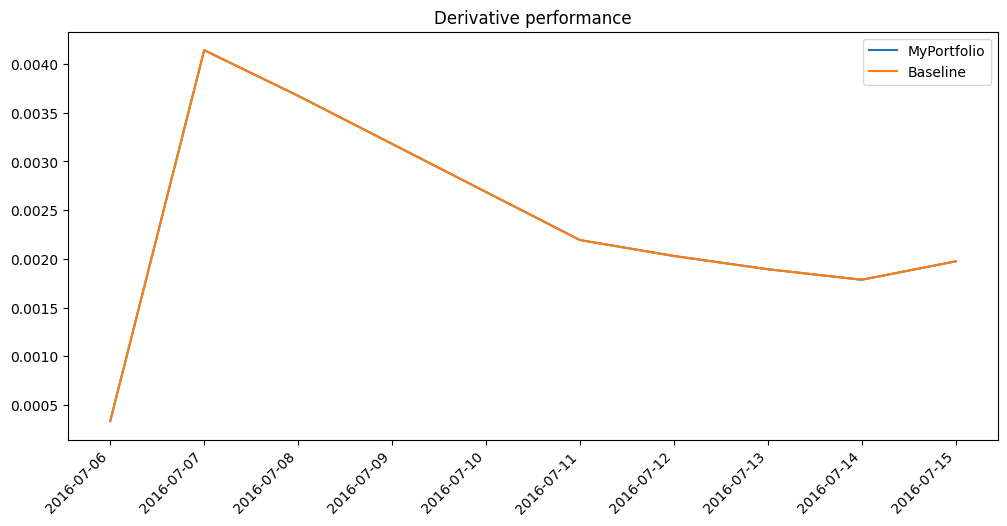

In [7]:
from tradeframework.api.insights import InsightManager

im = InsightManager(p)
im.addInsightGenerator(im.createInsightGenerator("BasicPlot", opts={"baseline": p.assets[0]}))
                                                 
results = im.generateInsights()

In [25]:
ppl.cropTime(p.assets[1].weights, start="19:00", end="20:00").values.sum()

DOW     
                           bar  gap
Date_Time                          
2016-07-06 19:00:00+00:00  1.0  0.0
2016-07-07 19:00:00+00:00  1.0  0.0
2016-07-08 19:00:00+00:00  1.0  0.0
2016-07-11 19:00:00+00:00  1.0  0.0
2016-07-12 19:00:00+00:00  1.0  0.0
2016-07-13 19:00:00+00:00  1.0  0.0
2016-07-14 19:00:00+00:00  1.0  0.0
2016-07-15 19:00:00+00:00  1.0  0.0

In [21]:
x = marketData.xs("DOW")
x = ppl.localize(x, "UTC", "US/Eastern")
x.to_csv("test.csv")

In [28]:
crop = ppl.cropTime(x, "15:00", "16:00")
idx = [x.index.get_loc(crop.index[z]) for z in range(len(crop))]
idx

[19, 43, 67, 90, 114, 138, 162, 186]